<a href="https://colab.research.google.com/github/kjahan/semantic_similarity/blob/image_encoder/examples/colab/img_auto_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image auto encoder

## Install packages

Ref: https://medium.com/analytics-vidhya/image-similarity-model-6b89a22e2f1a

In [4]:
import os


import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf


from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
DATA_PATH = '../content/gdrive/MyDrive/dataset/dataset'

## Split dataset to Train/Test

In [12]:
# Extracting image paths
file_path = os.listdir(DATA_PATH)
print(len(file_path))

train_files, test_files = train_test_split(file_path, test_size = 0.15)

print("Number of Training Images:",len(train_files))
print("Number of Test Images: ",len(test_files))
train_files = pd.DataFrame(train_files, columns=['filepath'])
test_files = pd.DataFrame(test_files, columns=['filepath'])

# converting into .csv file for future reference.
train_files.to_csv('train_file.csv')
test_files.to_csv('test_file.csv')

4788
Number of Training Images: 4069
Number of Test Images:  719


## Read images

In [13]:
def image2array(file_array, data_path):
    """
    Reading and Converting images into numpy array by taking path of images.
    Arguments:
    file_array - (list) - list of file(path) names
    Returns:
    A numpy array of images. (np.ndarray)
    """

    image_array = []
    for fn in tqdm(file_array):
        img = cv2.imread(data_path + '/' + fn)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(np.array(img))

    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3)
    image_array = image_array.astype('float32')
    image_array /= 255

    return np.array(image_array)

In [14]:
train_data = image2array(train_files['filepath'].tolist()[:100], DATA_PATH)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files['filepath'].tolist()[:10], DATA_PATH)
print("Length of test dataset:",test_data.shape)

100%|██████████| 10/10 [00:00<00:00, 125.23it/s]

Length of training dataset: (100, 224, 224, 3)
Length of test dataset: (10, 224, 224, 3)


## Construct model

In [15]:
def encoder_decoder_model():

    """
    Used to build Convolutional Autoencoder model architecture to get compressed image data which is easier to process.
    Returns:
    Auto encoder model
    """

    #Encoder 
    model = Sequential(name='Convolutional_AutoEncoder_Model')
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 3),padding='same', name='Encoding_Conv2D_1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
    model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

    #Decoder
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_1'))
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_3'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_5'))
    model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='Decoding_Output'))

    return model

In [16]:
model = encoder_decoder_model()
model.summary()

Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_Conv2D_1 (Conv2D)   (None, 224, 224, 64)      1792      
_________________________________________________________________
Encoding_MaxPooling2D_1 (Max (None, 112, 112, 64)      0         
_________________________________________________________________
Encoding_Conv2D_2 (Conv2D)   (None, 112, 112, 128)     73856     
_________________________________________________________________
Encoding_MaxPooling2D_2 (Max (None, 56, 56, 128)       0         
_________________________________________________________________
Encoding_Conv2D_3 (Conv2D)   (None, 56, 56, 256)       295168    
_________________________________________________________________
Encoding_MaxPooling2D_3 (Max (None, 28, 28, 256)       0         
_________________________________________________________________
Encoding_Conv2D_4 (Conv2D)   (None,

## Train

In [17]:
optimizer = Adam(learning_rate=0.001) 
model = encoder_decoder_model() 
model.compile(optimizer=optimizer, loss='mse') 
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.0001) 
checkpoint = ModelCheckpoint('encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_data, train_data, epochs=35, batch_size=32,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint])

Epoch 1/35
4/4 [==============================] - 98s 22s/step - loss: 2.0691 - val_loss: 1.5625
Epoch 2/35
4/4 [==============================] - 93s 21s/step - loss: 1.4150 - val_loss: 1.0375
Epoch 3/35
4/4 [==============================] - 93s 21s/step - loss: 0.9330 - val_loss: 0.6686
Epoch 4/35
4/4 [==============================] - 92s 21s/step - loss: 0.5990 - val_loss: 0.4309
Epoch 5/35
4/4 [==============================] - 93s 21s/step - loss: 0.3850 - val_loss: 0.2782
Epoch 6/35
4/4 [==============================] - 95s 22s/step - loss: 0.2562 - val_loss: 0.1926
Epoch 7/35
4/4 [==============================] - 93s 21s/step - loss: 0.1827 - val_loss: 0.1456
Epoch 8/35
4/4 [==============================] - 93s 21s/step - loss: 0.1416 - val_loss: 0.1186
Epoch 9/35
4/4 [==============================] - 93s 21s/step - loss: 0.1179 - val_loss: 0.1015
Epoch 10/35
4/4 [==============================] - 93s 21s/step - loss: 0.1021 - val_loss: 0.0905
Epoch 11/35
4/4 [============

In [19]:
from keras import backend as K

def feature_extraction(model, data, layer = 14):

    """
    Creating a function to run the initial layers of the encoder model. (to get feature extraction from any layer of the model)
    Arguments:
    model - (Auto encoder model) - Trained model
    data - (np.ndarray) - list of images to get feature extraction from trained model
    layer - (int) - from which layer to take the features(by default = 4)
    Returns:
    pooled_array - (np.ndarray) - array of extracted features of given images
    """

    encoded = K.function([model.layers[0].input],[model.layers[layer].output])
    encoded_array = encoded([data])[0]
    pooled_array = encoded_array.max(axis=-1)
    return encoded_array

encoded = feature_extraction(model, train_data[:10], 9)

In [24]:
encoded.shape

(10, 7, 7, 512)

In [30]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt

if Number of clusters: 4


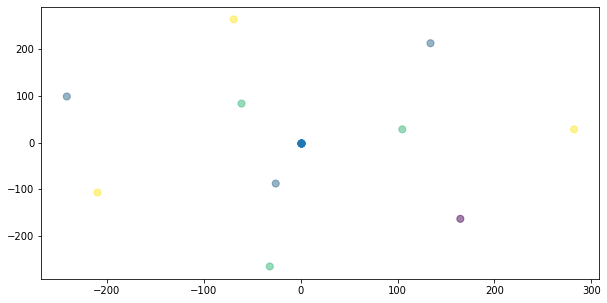

NameError: ignored

<Figure size 936x216 with 0 Axes>

In [35]:
# dimensionality reduction for visualization
transform = TSNE 
trans = transform(n_components=2) 

X_encoded_reshape = encoded.reshape((10, 25088))


values = trans.fit_transform(X_encoded_reshape) 

K = [4,5,6,7] #hyper parameter tuning
for k in K:
    print("if Number of clusters: "+str(k))
    #clustering the data
    kmeans = KMeans(n_clusters = k, random_state=0).fit(X_encoded_reshape)
    labels=kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,1,1)
    plt.scatter(values[:,0], values[:,1], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=None, s=50)
    plt.show()
    for row in range(k): 
        iter=0
        plt.figure(figsize=(13,3))
        for i,iterator in enumerate(labels):
            if iterator == row:
                # img = cv2.imread(DATA_PATH+lisp[i])
                img = cv2.imread(DATA_PATH + "/1.jpg")
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                plot_(img, "", "", 1, 6, iter+1, "cluster="+str(row),"","","",True)
                iter+=1
            if iter>=5: break
        plt.show()
    print() 